In [ ]:
from constants import DatasetPath

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import timm
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# Device to run calculations on 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#CYCLE_GAN and PRO_GAN contains both real and fake images

REAL_DIRS = ["afhq", "celebahq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces", "cycle_gan", "pro_gan"]

FAKE_DIRS = ["big_gan", "cips", "cycle_gan", "ddpm", "denoising_diffusion_gan", "diffusion_gan", "face_synthetics", 
				 "gansformer", "gau_gan", "generative_inpainting", "glide", "lama", "latent_diffusion", "mat", "palette", 
				 "pro_gan", "projected_gan", "sfhq", "stable_diffusion", "star_gan", "stylegan1", "stylegan2", "stylegan3",
				 "taming_transformer", "vq_diffusion"]

In [ ]:
def df_to_csv(df, filename, path):
	"""
	Splits the DataFrame in chunks to enable tqdm progress visualization while converting the DataFrame into a '.csv' file.

	Parametres
	----------
		df (pd.DataFrame): the DataFrame to convert.
		filename (str): the desired file name (comprehensive of '.csv' extension).
		path (str): the path where the '.csv' will be stored.
	"""
	chunks = np.array_split(df.index, 100)
	for chunck, subset in enumerate(tqdm(chunks, desc="Creating \'" + filename + "\' file")):
		if chunck == 0: # first row
			df.loc[subset].to_csv(path, mode='w', index=False)
		else:
			df.loc[subset].to_csv(path, header=None, mode='a', index=False)

	print("\'" + filename + "\' has been successfully created.")

In [ ]:
df = pd.read_csv(DATA_DIR + "pre_trainingSet.csv")

# PLOT GENERATION FUNCTIONS

In [ ]:
def plot_path_frequency_as_positive(df):
	"""
	Plot the frequency of paths in the 'positive' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'positive'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'positive' column with paths.
	"""
	
	# Calculate the frequency of 'positive' paths
	positive_counts = df['positive'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	positive_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Positive\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_path_frequency_as_negative(df):
	"""
	Plot the frequency of paths in the 'negative' column of the DataFrame.

	This function calculates the frequency of each unique path in the 'negative'
	column of the provided DataFrame and plots the top 20 most frequent paths
	as a bar chart.

	Parameters
	----------
	df (pandas.DataFrame): the DataFrame containing the 'negative' column with paths.
	"""
	# Calculate the frequency of 'negative' paths
	negative_counts = df['negative'].value_counts()

	# Create the bar plot
	plt.figure(figsize=(25, 5))
	negative_counts.head(20).plot(kind='bar')
	plt.title('Most Frequent Paths as \'Negative\'')
	plt.xlabel('Path')
	plt.ylabel('Frequency')
	plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
	plt.show()

def plot_real_fake_count(df, dataset_partition_path):
	"""
	Plot the count of 'real' and 'fake' images based on the target information from a separate CSV file.

	This function merges the DataFrame containing image paths with another DataFrame that categorizes
	each image as 'real' or 'fake' based on the 'target' column. It then plots these counts as a horizontal bar chart.

	Parameters
	----------
	df (pandas.DataFrame): DataFrame containing 'anchor', 'positive', and 'negative' columns with image paths.
	dataset_partition_path (str): Path to the CSV file containing 'image_path' and 'target' columns.
	"""
	
	# Load the dataset partition DataFrame
	dataset_partition_df = pd.read_csv(dataset_partition_path)
	
	# Merge the anchor paths with the partition DataFrame to get their targets
	df = df.merge(dataset_partition_df, left_on='anchor', right_on='image_path', how='left')

	# Determine the 'Type' based on the 'target' column
	df['Type'] = df['target'].apply(lambda x: 'real' if x == 0 else 'fake')

	# Count occurrences of 'real' and 'fake'
	counts = df['Type'].value_counts()

	# Prepare data for plotting
	counts_df = pd.DataFrame(counts).reset_index()
	counts_df.columns = ['Type', 'Count']

	# Plot horizontal bar chart
	ax = counts_df.plot(kind='barh', x='Type', y='Count', legend=False, color=['blue', 'red'])
	plt.title('Number of images per category in the Training Set')
	plt.xlabel('Count')
	plt.ylabel('Type')

	# Add text annotations to the bars
	for index, value in enumerate(counts_df['Count']):
		ax.text(value, index, str(value), va='center')

	# Expand x-axis to accommodate annotations
	plt.xlim(right=max(counts_df['Count']) * 1.2)

	plt.show()


# MODEL DEFINITION

In [ ]:
class APN_Model(nn.Module):
	"""
	Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
	"""

	def __init__(self, emb_size = 512):
		"""
		Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

		Parameters
		----------
		emb_size (int, optional): the size of the output embedding vector (default is 512).
		"""
		super(APN_Model, self).__init__()

		# Define the model to use 
		self.efficientnet = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained = True)
		
		# Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
		self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

	def forward(self, images):
		"""
		Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

		Parameters
		----------
			images (torch.Tensor): a batch of images to process.

		Returns
		-------
			embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
		"""
		embeddings = self.efficientnet(images)
		return embeddings

In [ ]:
model = APN_Model()

model.to(DEVICE)

# EMBEDDINGS CALCULATION

In [ ]:
def getImageEmbeddings(img_path, model):
	"""
	Generates embeddings for a given image using the provided model.

	Parameters
	----------
		img_path (str): the path to the input image.
		model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

	Returns
	-------
		img_enc (numpy.ndarray): the embeddings of the input image.
	"""
	preprocess = transforms.Compose([
		transforms.ToTensor(),  # Convert the image to a PyTorch tensor and normalize pixel values to [0, 1]
		transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
	])

	# Read the image from the specified directory
	img = Image.open(DATA_DIR + img_path).convert('RGB')
	# Image preprocessing
	img = preprocess(img).unsqueeze(0)  # Add a batch dimension
	# Move the image tensor to the appropriate device (CPU or GPU)
	img = img.to(DEVICE)
	
	# Set the model to evaluation mode
	model.eval()
	
	# Disable gradient calculation for efficiency
	with torch.no_grad():
		
		# Pass the image through the model to get the embeddings
		img_enc = model(img)
		
		# Detach the embeddings from the computation graph and move them back to the CPU
		img_enc = img_enc.detach().cpu().numpy()

	return img_enc

In [ ]:
embedding_dict = {}  # Initialize an empty dictionary to store image embeddings

# Loop through each image path in the 'anchor' column of the DataFrame
for img_path in tqdm(df['image_path'], total=len(df), desc="Generating embeddings"):
	# Generate and store the embedding for each anchor image in the dictionary
	embedding_dict[img_path] = getImageEmbeddings(img_path, model)

Generating embeddings:   0%|          | 0/48000 [00:00<?, ?it/s]

In [ ]:
# Convert the embedding_dict into a DataFrame
# Ensure that each value in the dictionary is a one-dimensional array
embeddings_list = []
for path, emb in embedding_dict.items():
	# Ensure each embedding is a one-dimensional array, for example using numpy flatten
	if isinstance(emb, np.ndarray):
		emb = emb.flatten()
	embeddings_list.append([path] + emb.tolist())

# Create a DataFrame from embeddings_list
embeddings_df = pd.DataFrame(embeddings_list)
columns = ['path'] + [f'embedding_{i}' for i in range(len(embeddings_list[0]) - 1)]
embeddings_df.columns = columns

embeddings_df


,path,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,embedding_502,embedding_503,embedding_504,embedding_505,embedding_506,embedding_507,embedding_508,embedding_509,embedding_510,embedding_511
0,coco/coco/coco2017/test2017/img021550.jpg,-0.244415,-0.256052,0.135224,0.116094,0.265884,-0.187290,-0.013710,-0.115754,-0.137703,...,0.133959,0.136225,0.267477,-0.174719,0.042048,-0.134087,-0.026114,0.345190,-0.223316,0.294316
1,coco/coco/coco2017/train2017/img070651.jpg,0.185568,0.087436,0.083377,-0.035692,-0.116553,-0.090501,-0.024730,-0.122080,-0.122089,...,0.117680,-0.189590,-0.158147,0.025423,-0.048910,-0.115896,0.118314,-0.202838,-0.137253,0.133792
2,coco/coco/coco2017/train2017/img078157.jpg,0.253678,0.068044,0.001651,0.074566,0.063975,0.059329,0.037790,-0.105054,-0.112488,...,-0.166672,0.059906,0.028595,-0.093753,0.037268,0.095141,0.042679,-0.175210,-0.174855,-0.060439
3,coco/coco/coco2017/train2017/img141336.jpg,0.139336,0.118245,0.229342,0.016325,-0.011361,0.114189,0.047894,-0.234383,-0.105639,...,-0.116839,-0.103196,-0.039837,-0.051834,-0.159963,-0.165027,0.223837,0.026151,-0.230634,-0.148580
4,coco/coco/coco2017/train2017/img078071.jpg,-0.063328,0.446723,-0.092356,0.069953,-0.088379,-0.312652,0.166151,-0.028985,-0.313515,...,-0.093824,-0.066047,-0.180941,0.090583,0.271851,-0.189201,0.165127,0.410662,-0.155432,0.126445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...,0.018393,-0.001400,0.167824,0.237406,-0.079316,0.008015,0.029133,0.184092,-0.148193,...,0.028025,-0.060954,-0.069203,-0.063417,0.223655,-0.286727,0.050554,0.088436,0.204414,-0.085803
47996,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,0.189076,0.171870,0.031510,0.043116,0.034090,-0.393116,-0.158146,-0.136497,-0.345398,...,-0.142899,0.094747,-0.239710,-0.032183,0.047998,0.016116,-0.029711,-0.125769,0.103116,0.020674
47997,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,0.074043,-0.041191,-0.092733,0.116054,0.060933,-0.299931,0.073754,-0.263242,-0.000199,...,-0.019502,-0.101980,-0.426537,-0.338908,-0.026569,-0.336362,0.386539,0.201988,0.243470,-0.244283
47998,taming_transformer/tt-coco/samples_nopix/img00...,-0.003243,0.492009,-0.110870,0.282078,0.045796,0.111216,0.365109,-0.260231,0.013826,...,-0.029582,0.078611,0.073612,-0.139775,-0.150172,-0.129546,0.115334,0.080584,0.211241,0.180654


# TRIPLETS GENERATION (ONLINE SEMI-HARD MINING)

In [ ]:
def pairwise_distances(embeddings, squared=False):
    """
    Compute the 2D matrix of distances between all the embeddings.

    Parameters
    ----------
    embeddings : torch.Tensor
        Tensor of shape (batch_size, embed_dim) representing the embeddings.
    squared : bool, optional
        If True, output is the pairwise squared Euclidean distance matrix.
        If False, output is the pairwise Euclidean distance matrix.

    Returns
    -------
    torch.Tensor
        Tensor of shape (batch_size, batch_size) representing the pairwise distances.
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = torch.matmul(embeddings, embeddings.T)

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2 - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = square_norm.unsqueeze(1) - 2.0 * dot_product + square_norm.unsqueeze(0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.clamp(distances, min=0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = (distances == 0.0).float()
        distances = distances + mask * 1e-16

        distances = torch.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def classify_images(df):
    """
    Adds a 'classification' column to the DataFrame indicating whether images are real or fake.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with columns 'image_path' and 'target'.

    Returns
    -------
    df : pandas.DataFrame
        Updated DataFrame with a new 'classification' column where 'real' or 'fake' is specified.
    """
    # Determine 'classification' based on 'target' column
    df['classification'] = df['target'].apply(lambda x: 'real' if x == 0 else 'fake')
    return df

def create_semi_hard_triplets(df, embedding_dict, margin=0.2):
    """
    Creates semi-hard triplets from the provided embeddings where if the anchor is 'real' 
    the positive is 'real' and the negative is 'fake'.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'image_path' and 'target'.
    embedding_dict : dict
        Dictionary mapping image paths to embeddings.
    margin : float
        Margin for semi-hard triplet selection.
        
    Returns
    -------
    triplets_df : pandas.DataFrame
        DataFrame containing the anchor, positive, and negative triplets.
    """
    # Classify images directly in the DataFrame
    df = classify_images(df)

    # Create a list of embeddings in the same order as image paths in df
    image_paths = df['image_path'].tolist()
    embeddings_list = [np.ravel(embedding_dict[path]) for path in tqdm(image_paths, desc="Loading embeddings")]
    embeddings = torch.tensor(np.array(embeddings_list))

    # Compute the distance matrix
    distance_matrix = pairwise_distances(embeddings)
    
    triplets = []
    used_anchors = set()  # Track used anchors to ensure each is only used once

    for i, anchor_path in enumerate(tqdm(image_paths, desc="Generating triplets")):
        if anchor_path in used_anchors:
            continue  # Skip if anchor already used
        
        anchor_class = df.iloc[i]['classification']
        
        # Select positive and negative pools based on classification
        positive_indices = df[(df['classification'] == anchor_class) & (df['image_path'] != anchor_path)].index
        negative_indices = df[df['classification'] != anchor_class].index
        
        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue  # Skip if there are no valid positives or negatives
        
        # Find the closest positive
        positive_distances = distance_matrix[i, positive_indices].cpu().numpy()
        positive_idx = positive_indices[np.argmin(positive_distances)]
        positive_path = df.iloc[positive_idx]['image_path']
        anchor_positive_distance = np.min(positive_distances)
        
        # Find semi-hard negatives
        negative_distances = distance_matrix[i, negative_indices].cpu().numpy()
        semi_hard_negatives = negative_indices[
            (negative_distances > anchor_positive_distance) & 
            (negative_distances < anchor_positive_distance + margin)
        ]
        
        if len(semi_hard_negatives) > 0:
            negative_idx = semi_hard_negatives[0]  # Take the first semi-hard negative
            negative_path = df.iloc[negative_idx]['image_path']
            triplets.append([anchor_path, positive_path, negative_path])
            used_anchors.add(anchor_path)  # Mark this anchor as used

    triplets_df = pd.DataFrame(triplets, columns=['anchor', 'positive', 'negative'])
    return triplets_df

In [ ]:
triplets_df = create_semi_hard_triplets(df, embedding_dict)
df_to_csv(triplets_df, "trainingSet.csv", DATA_DIR + "trainingSet.csv")
triplets_df

Loading embeddings:   0%|          | 0/48000 [00:00<?, ?it/s]

Generating triplets:   0%|          | 0/48000 [00:00<?, ?it/s]

Creating 'trainingSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'trainingSet.csv' has been successfully created.


,anchor,positive,negative
0,coco/coco/coco2017/train2017/img070651.jpg,coco/coco/coco2017/train2017/img104261.jpg,big_gan/big/biggan-data/598/img005542.jpg
1,coco/coco/coco2017/train2017/img078157.jpg,coco/coco/coco2017/train2017/img087258.jpg,latent_diffusion/latentdiff-t2i/images/img0094...
2,coco/coco/coco2017/train2017/img141336.jpg,imagenet/imagenet/train/n04264628/img064846.jpg,latent_diffusion/latentdiff-t2i/images/img0005...
3,coco/coco/coco2017/train2017/img078071.jpg,coco/coco/coco2017/test2017/img033674.jpg,big_gan/big/biggan-data/589/img005443.jpg
4,coco/coco/coco2017/test2017/img021118.jpg,coco/coco/coco2017/test2017/img006282.jpg,latent_diffusion/latentdiff-t2i/images/img0029...
...,...,...,...
21440,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,latent_diffusion/latentdiff/313/img002396.jpg,imagenet/imagenet/train/n04118776/img061526.jpg
21441,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,latent_diffusion/latentdiff/497/img004423.jpg,lsun/church/church/train/img004865.jpg
21442,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,imagenet/imagenet/train/n01773549/img005868.jpg
21443,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...,big_gan/big/biggan-data/171/img000819.jpg,imagenet/imagenet/train/n02091134/img013811.jpg


# DATA VISUALIZATION

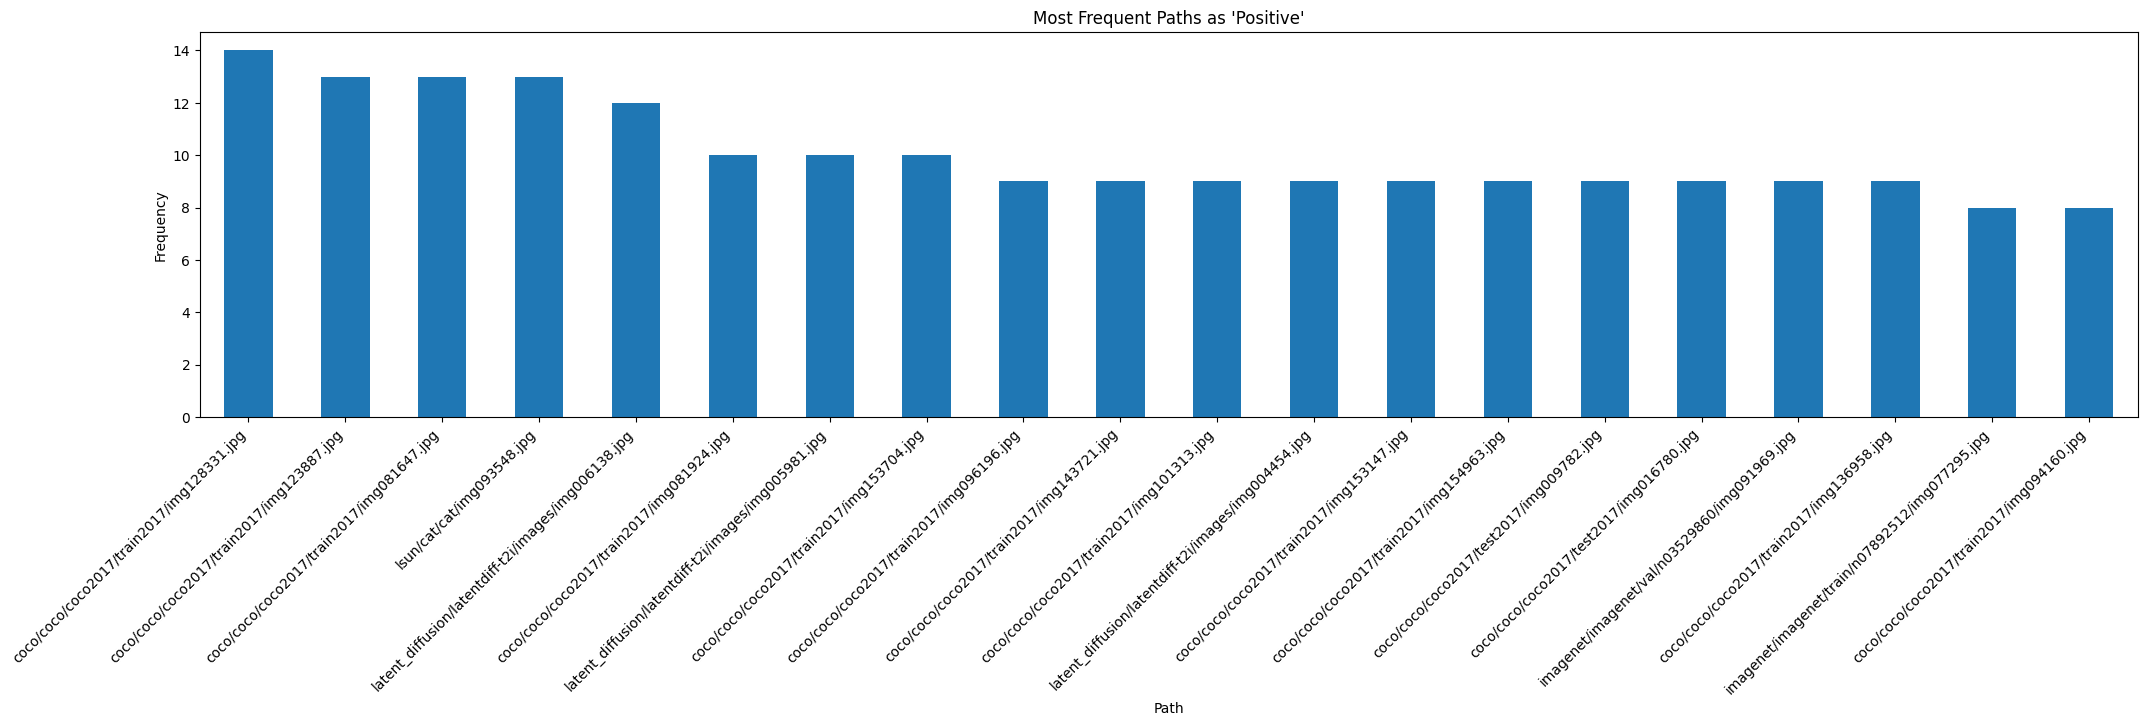

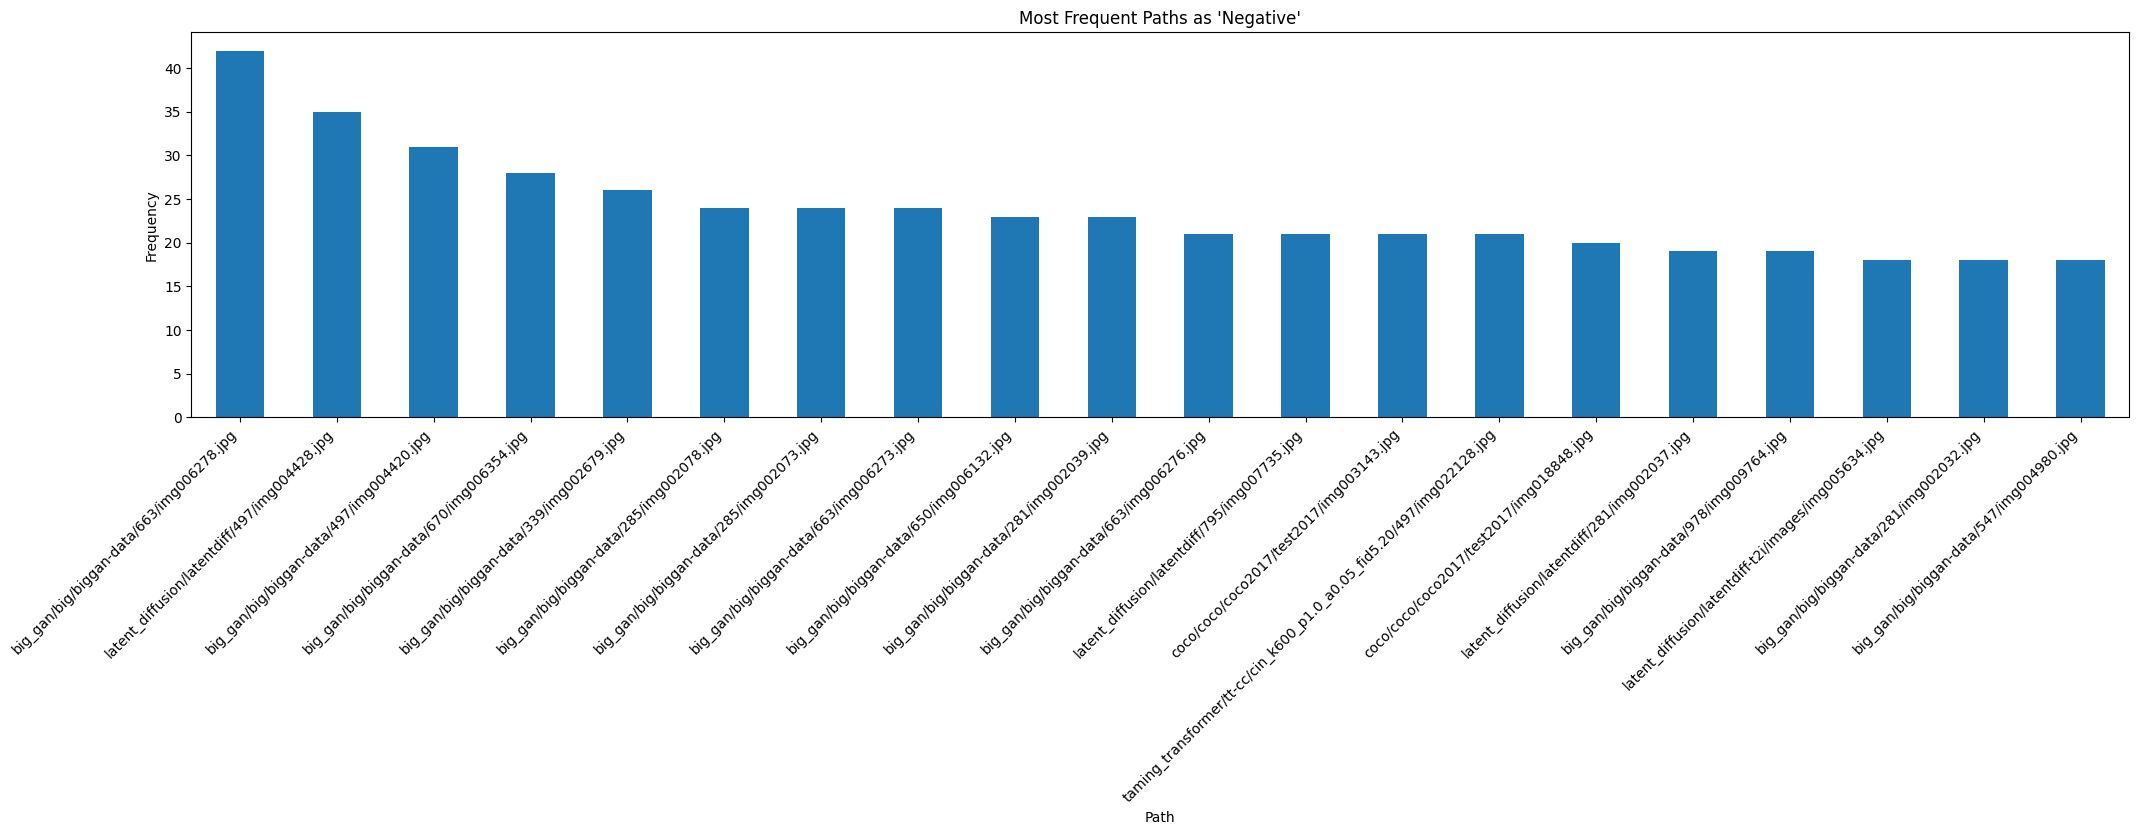

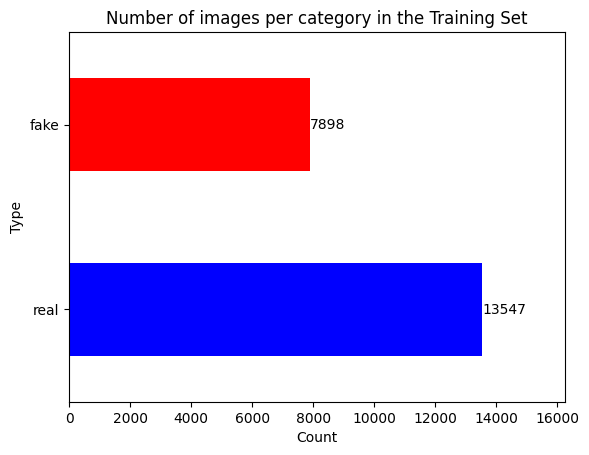

In [ ]:
plot_path_frequency_as_positive(triplets_df)
plot_path_frequency_as_negative(triplets_df)
plot_real_fake_count(triplets_df, DATA_DIR + "dataset_partition.csv")

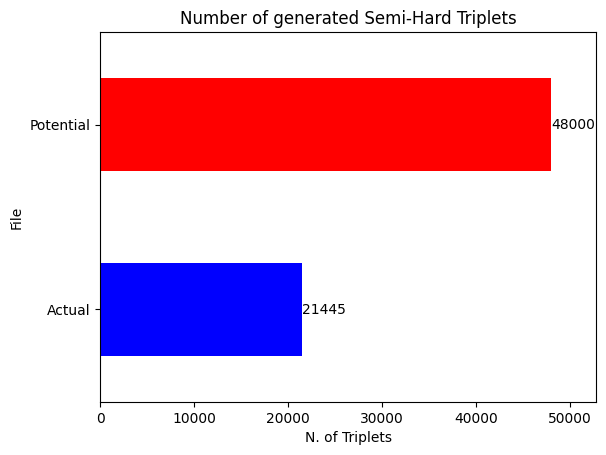

In [ ]:
# Read lengths of CSV files
potential_triplets = len(df)
actual_triplets = len(triplets_df)

# Prepare data for plotting
lengths = {'Actual': actual_triplets, 'Potential': potential_triplets}
lengths_df = pd.DataFrame(list(lengths.items()), columns=['File', 'Length'])

# Plot horizontal bar chart
ax = lengths_df.plot(kind='barh', x='File', y='Length', legend=False, color=['blue', 'red'])
plt.title('Number of generated Semi-Hard Triplets')
plt.xlabel('N. of Triplets')
plt.ylabel('File')

# Add text annotations to the bars
for index, value in enumerate(lengths_df['Length']):
	ax.text(value, index, str(value), va='center')

# Expand x-axis to accommodate annotations
plt.xlim(right=max(lengths_df['Length']) * 1.1)

plt.show()

In [ ]:
# The following code adresses the issue with path differences beetween Google and Windows when colab is used 
# (This doesn't change anything if colab wasn't used)

# Replace '\' with '/' in the whole file
df = df.applymap(lambda x: x.replace('/', '\\') if isinstance(x, str) else x)

# Overwrite the '.csv' file with the updated DataFrame
if os.path.exists(DATA_DIR + "filtered_input.csv"):
		os.remove(DATA_DIR + "filtered_input.csv")
df.to_csv(DATA_DIR + "filtered_input.csv", index=False)

C:\Users\mario\AppData\Local\Temp\ipykernel_20992\4106481676.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('/', '\\') if isinstance(x, str) else x)


# TEST SET REBALANCE

In [ ]:
def get_input_dirs(filtered_input_df):
	"""
	Retrieves image source directories from the dataset.

	Parameters
	----------
		filtered_input_df (pandas.DataFrame): the dataframe containing the semi-hard mined triplets.
	Returns
	-------
		real_dirs (set of str): a set of unique directories that contain real images.
		fake_dirs (set of str): a set of unique directories that contain fake images.
	"""
	# Initialize lists to store directories for real and fake images
	real_dirs_list = []
	fake_dirs_list = []

	# Iterate through each row in the dataframe with a progress bar
	for index, row in tqdm(filtered_input_df.iterrows(), total=filtered_input_df.shape[0]):
		# Extract the top-level directory from the image path
		dir = row["anchor"].split('/')[0]

		# Categorize the directory as 'real' or 'fake' based on its presence in REAL_DIRS
		if dir in REAL_DIRS:
			real_dirs_list.append(dir)
		else:
			fake_dirs_list.append(dir)

	real_dirs = sorted(set(real_dirs_list))
	fake_dirs = sorted(set(fake_dirs_list))

	# Return the lists of real and fake directories
	return real_dirs, fake_dirs


def train_test_split_rebalance(train_df, test_df):
	"""
	Rebalances the test dataset to achieve an 80/20 train-test split ratio.

	This function rebalances the test dataset by dropping a calculated number of 
	samples from each directory of real and fake images to achieve an 80/20 
	train-test split ratio. The function also saves the old test set before 
	rebalancing.

	Parameters
	----------
	filtered_input_df (pandas.DataFrame): the DataFrame containing the filtered input data.
	test_df (pandas.DataFrame): the DataFrame containing the initial test data.

	Notes
	-----
	- This function assumes the presence of 'real' and 'fake' columns in the 
	  `test_df` DataFrame, which contain paths to the real and fake images, 
	  respectively.
	- The function will save the old test set to a CSV file named 
	  "unbalanced_testSet.csv" and the rebalanced test set to a CSV file named 
	  "testSet.csv" in the directory specified by `DATA_DIR`.
	- The function uses the helper function `get_input_dirs` to obtain directories 
	  containing real and fake images and `df_to_csv` to save DataFrames to CSV files.
	"""
	
	# Initialization
	balanced_test_df = pd.DataFrame(columns=['real', 'fake'])
	input_size = len(train_df)
	real_dirs, fake_dirs = get_input_dirs(train_df)
	print(real_dirs)
	print(fake_dirs)

	rebalanced_size = round(input_size * 20 / 80)
	print(f"Current Test set size:{len(test_df) * 2}(Train-Test split ratio: {(input_size * 100 / (input_size + (len(test_df)* 2))):.2f}/{(len(test_df) * 2 * 100 / (input_size + (len(test_df)* 2))):.2f})")
	print(f"Balanced Test set size:{rebalanced_size}(Train-Test split ratio: 80/20)")

	# Number of tuples to sample from each real images directory
	real_sample_size = round(rebalanced_size / 2 / len(real_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(real_dirs, desc="Test set Real images sampling"):
		sampled_size = 0
		for index, row in test_df.iterrows():
			if sampled_size < real_sample_size:
				image_path = row["real"]
				splitted_path = image_path.split('/')[0]
				if dir==splitted_path:
					balanced_test_df.loc[i] = [image_path, None]
					sampled_size+=1
					i+=1
			else: break
	
	# Number of tuples to sample from each fake images directory
	fake_sample_size = round(rebalanced_size / 2 / len(fake_dirs))
	i = 1
	#Iterate through the dataset partition and sample the same number of tuples for each fake images directory
	for dir in tqdm(fake_dirs, desc="Test set Fake images sampling"):
			sampled_size = 0
			for index, row in test_df.iterrows():
					if sampled_size < fake_sample_size:
							image_path = row["fake"]
							splitted_path = image_path.split('/')[0]
							if dir == splitted_path:
									balanced_test_df.loc[i] = [balanced_test_df.loc[i]["real"], image_path]
									sampled_size+=1
									i+=1

					else: break
	
	print(f"Test Set size after operations:{len(balanced_test_df) * 2}")

	# Store the old version of the Test Set and Overwrite the Test Set with the rebalanced one
	df_to_csv(test_df, "unbalanced_testSet.csv", DATA_DIR + "unbalanced_testSet.csv")
	if os.path.exists(DATA_DIR + "testSet.csv"):
		os.remove(DATA_DIR + "testSet.csv")
	df_to_csv(balanced_test_df, "testSet.csv", DATA_DIR + "testSet.csv") 

In [ ]:
test_df = pd.read_csv(DATA_DIR + "testSet.csv")

train_test_split_rebalance(triplets_df, test_df)

  0%|          | 0/21445 [00:00<?, ?it/s]

['coco', 'imagenet', 'lsun']
['big_gan', 'latent_diffusion', 'taming_transformer']
Current Test set size:12000(Train-Test split ratio: 64.12/35.88)
Balanced Test set size:5361(Train-Test split ratio: 80/20)


Test set Real images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test set Fake images sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Test Set size after operations:5364


Creating 'unbalanced_testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'unbalanced_testSet.csv' has been successfully created.


Creating 'testSet.csv' file:   0%|          | 0/100 [00:00<?, ?it/s]

'testSet.csv' has been successfully created.


In [ ]:
test_df

,real,fake
0,coco/coco/coco2017/test2017/img034161.jpg,big_gan/big/biggan-data/472/img004157.jpg
1,coco/coco/coco2017/train2017/img123159.jpg,big_gan/big/biggan-data/472/img004159.jpg
2,coco/coco/coco2017/train2017/img051061.jpg,big_gan/big/biggan-data/856/img008416.jpg
3,coco/coco/coco2017/test2017/img034059.jpg,big_gan/big/biggan-data/924/img009171.jpg
4,coco/coco/coco2017/train2017/img071200.jpg,big_gan/big/biggan-data/383/img003163.jpg
...,...,...
5995,imagenet/imagenet/val/n04005630/img094869.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...
5996,imagenet/imagenet/train/n02093859/img014681.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...
5997,imagenet/imagenet/train/n01534433/img001050.jpg,taming_transformer/tt-ffhq/ffhq_k300_p1.0_fid9...
5998,imagenet/imagenet/train/n03125729/img041337.jpg,taming_transformer/tt-cc/cin_k600_p1.0_a0.05_f...
